In [1]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
import pickle
import seaborn as sns

from torch_geometric.utils import to_networkx
#install required packages
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt

from torch_geometric.data import Dataset
import torch_geometric.utils as pyg_utils
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool,GATv2Conv
from torch_geometric.nn.models import GCN, GAT
from torch.nn import Linear

from torch_geometric.utils import degree

import torch.nn as nn
from torch_geometric.utils import softmax
import math
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr, spearmanr
import random
from sklearn.metrics import root_mean_squared_error,mean_absolute_error
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import esm

2.4.1+cu118


In [2]:

def set_seed(seed):
    random.seed(seed)  # Python random
    np.random.seed(seed)  # Numpy random
    torch.manual_seed(seed)  # PyTorch CPU
    torch.cuda.manual_seed(seed)  # PyTorch GPU (un singolo dispositivo)
    torch.cuda.manual_seed_all(seed)  # PyTorch GPU (tutti i dispositivi, se usi multi-GPU)
    torch.backends.cudnn.deterministic = True  # Comportamento deterministico di cuDNN
    torch.backends.cudnn.benchmark = False  # Evita che cuDNN ottimizzi dinamicamente (influisce su riproducibilità)

# Imposta il seed
set_seed(42)


In [3]:

# Carica il modello pre-addestrato ESM2
model_esm, alphabet_esm = esm.pretrained.esm2_t33_650M_UR50D()
#esm.pretrained.esm2_t48_15B_UR50D() #esm.pretrained.esm2_t33_650M_UR50D()

# #modelli possibili 
# esm.pretrained.esm2_t6_8M_UR50D()   # Modello più piccolo (8 milioni di parametri)
# esm.pretrained.esm2_t33_650M_UR50D() # Modello medio (650 milioni di parametri)
# esm.pretrained.esm2_t36_3B_UR50D()   # Modello più grande (3 miliardi di parametri)

# Sposta il modello su GPU, se disponibile
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_esm = model_esm.to(device)
batch_converter_esm = alphabet_esm.get_batch_converter()
model_esm.eval()


def Esm2_embedding(seq, model_esm = model_esm, batch_converter_esm = batch_converter_esm):
    # Definisci la sequenza della proteina
    sequences = [("protein", seq),]
    
    # Converte la sequenza nel formato richiesto dal modello
    batch_labels, batch_strs, batch_tokens = batch_converter_esm(sequences)
    batch_tokens = batch_tokens.to(device)
    #batch_lens = (batch_tokens != alphabet.padding_idx).sum(1)

    # Disabilita il calcolo del gradiente per risparmiare memoria
    with torch.no_grad():
        results = model_esm(batch_tokens, repr_layers=[33])  # Usa l'ultimo layer
        token_representations = results["representations"][33]
    
    # Rimuove i token speciali di inizio/fine sequenza
    # L'embedding risultante sarà una matrice (Lunghezza della sequenza, Dimensione dell'embedding)
    embedding = token_representations[0, 1:-1].cpu().numpy()
    return embedding

In [4]:
from random import sample

class DeltaDataset(Dataset):
    def __init__(self, data, dim_embedding, inv = False):
        self.data = data
        self.dim_embedding = dim_embedding
        self.inv = inv

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.inv: 
            return {
                'id': sample['id'],
                'wild_type': torch.tensor(sample['mut_type'], dtype=torch.float32),    #inverto mut con wild 
                'mut_type': torch.tensor(sample['wild_type'], dtype=torch.float32),    #inverto mut con wild             
                'length': torch.tensor(sample['length'], dtype=torch.float32),
                'ddg': torch.tensor(-float(sample['ddg']), dtype=torch.float32),       # -ddg
                #'alpha_vec': torch.tensor(-sample['alpha_vec'], dtype=torch.float32),  #-V
                'pos_mut': torch.tensor(sample['pos_mut'], dtype=torch.int64),
                }|{AA:torch.tensor(sample[AA], dtype=torch.float32) for AA in "ACDEFGHIKLMNPQRSTVWY"}

        else:
            return {
                'id': sample['id'],
                'wild_type': torch.tensor(sample['wild_type'], dtype=torch.float32),
                'mut_type': torch.tensor(sample['mut_type'],dtype=torch.float32),
                'length': torch.tensor(sample['length'], dtype=torch.float32),
                'ddg': torch.tensor(float(sample['ddg']), dtype=torch.float32),
                #'alpha_vec': torch.tensor(sample['alpha_vec'], dtype=torch.float32),
                'pos_mut': torch.tensor(sample['pos_mut'], dtype=torch.int64),
                }|{AA:torch.tensor(sample[AA], dtype=torch.float32) for AA in "ACDEFGHIKLMNPQRSTVWY"}


In [5]:

#from torch_geometric.loader import DataLoader
import random
#from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.utils.data import DataLoader  # Use standard PyTorch DataLoader


import torch
import torch.nn.functional as F

def collate_fn(batch):
    max_len = max(sample['wild_type'].shape[0] for sample in batch)  # Max sequence length in batch   700
    max_features = max(sample['wild_type'].shape[1] for sample in batch)  # Max feature size

    padded_batch = {
        'id': [],
        'wild_type': [],
        'mut_type': [],
        'length': [],
        'ddg': [],
        #'alpha_vec': [],
        'pos_mut': []
    }|{AA:[] for AA in "ACDEFGHIKLMNPQRSTVWY"}

    for sample in batch:
        wild_type_padded = F.pad(sample['wild_type'], (0, max_features - sample['wild_type'].shape[1], 
                                                       0, max_len - sample['wild_type'].shape[0]))
        mut_type_padded = F.pad(sample['mut_type'], (0, max_features - sample['mut_type'].shape[1], 
                                                     0, max_len - sample['mut_type'].shape[0]))

        for AA in "ACDEFGHIKLMNPQRSTVWY":
            sample[AA] = F.pad(sample[AA], (0, max_features - sample['mut_type'].shape[1], 
                                                     0, max_len - sample['mut_type'].shape[0]))

        padded_batch['id'].append(sample['id'])  
        padded_batch['wild_type'].append(wild_type_padded)  
        padded_batch['mut_type'].append(mut_type_padded)  
        padded_batch['length'].append(sample['length'])#append(torch.tensor(sample['length'], dtype=torch.float32))  
        padded_batch['ddg'].append(sample['ddg'])#append(torch.tensor(float(sample['ddg']), dtype=torch.float32))  
        #padded_batch['alpha_vec'].append(sample['alpha_vec'])#append(torch.tensor(sample['alpha_vec'], dtype=torch.float32))  
        padded_batch['pos_mut'].append(sample['pos_mut'])#append(torch.tensor(sample['pos_mut'], dtype=torch.int64))
        for AA in "ACDEFGHIKLMNPQRSTVWY":
            padded_batch[AA].append(sample[AA])
    

    # Convert list of tensors into a single batch tensor
    padded_batch['wild_type'] = torch.stack(padded_batch['wild_type'])  # Shape: (batch_size, max_len, max_features)
    padded_batch['mut_type'] = torch.stack(padded_batch['mut_type'])  
    padded_batch['length'] = torch.stack(padded_batch['length'])  
    padded_batch['ddg'] = torch.stack(padded_batch['ddg'])  
    #padded_batch['alpha_vec'] = torch.stack(padded_batch['alpha_vec'])  
    padded_batch['pos_mut'] = [torch.stack(padded_batch['pos_mut'])]
    
    for AA in "ACDEFGHIKLMNPQRSTVWY":
        padded_batch[AA]= torch.stack(padded_batch[AA])

    return padded_batch


In [6]:
import copy

def output_model_from_batch(batch, model, device, train=True):

    '''Dato un modello pytorch e batch restituisce: output_modello, True labels'''
    
    x_wild = batch['wild_type'].float().to(device)
    x_mut = batch['mut_type'].float().to(device)
    labels = batch['ddg'].float().to(device)
    length = batch['length'].to(device)
    output_ddg = model(x_wild, x_mut, length, train = train)
    
    return output_ddg, labels, batch['pos_mut']   #prova a vedere pos mut




In [7]:
# class Cross_Attention_DDG(nn.Module):
    
#     def __init__(self, base_module, cross_att=False, dual_cross_att= False,**transf_parameters):
#         super().__init__()
#         self.base_ddg = base_module(**transf_parameters, cross_att=cross_att, dual_cross_att= dual_cross_att).to(device)
    
#     def forward(self, x_wild, x_mut,hydra_list, length, train = True):

#         delta_x_dir = x_wild - x_mut
#         output_TCA_dir = self.base_ddg(delta_x_dir, x_wild, length)

#         # delta_x_inv = x_mut-x_wild
#         # output_TCA_inv = self.base_ddg(delta_x_inv, x_mut, length)
        
#         return output_TCA_dir #(output_TCA_dir-output_TCA_inv)/2#output_TCA   



In [8]:


def output_model_from_batch_HYDRA(batch, model, device,train=True):

    '''Dato un modello pytorch e batch restituisce: output_modello, True labels'''
    
    x_wild = batch['wild_type'].float().to(device)
    x_mut = batch['mut_type'].float().to(device)
    hydra_list = [batch[aa].to(device) for aa in 'ACDEFGHIKLMNPQRSTVWY']
    labels = batch['ddg'].float().to(device)
    length = batch['length'].to(device)
    output_ddg = model(x_wild, x_mut, hydra_list, length, train = train)
    
    return output_ddg, labels, batch['pos_mut']   #prova a vedere pos mut

class Cross_Attention_DDG(nn.Module):
    
    def __init__(self, base_module, cross_att=False, dual_cross_att= False, hydra=True ,**transf_parameters):
        super().__init__()
        self.base_ddg = base_module(**transf_parameters, cross_att=cross_att, dual_cross_att= dual_cross_att).to(device)
        self.hydra=hydra
    
    def forward(self, x_wild, x_mut, hydra_list, length, train = True):

       # Generiamo N numeri casuali
        indices = [random.randint(0, 19) for _ in range(N)]
        half_aas = [hydra_list[i] for i in indices]
        
        # Calcolo DDG tra wild e primo intermezzo
        delta_dir = x_wild - half_aas[0]
        #delta_inv = half_aas[0] - x_wild
        wild_half_DDG = self.base_ddg(delta_dir, x_wild, length)#(self.base_ddg(delta_dir, x_wild, length) - self.base_ddg(delta_inv, half_aas[0], length)) / 2
        
        # Calcolo DDG tra gli intermezzi
        intermezzi_DDG = 0
        for i in range(N - 1):
            delta_dir = half_aas[i] - half_aas[i + 1]
            #delta_inv = half_aas[i + 1] - half_aas[i]
            intermezzi_DDG += self.base_ddg(delta_dir, half_aas[i], length)#(self.base_ddg(delta_dir, half_aas[i], length) - self.base_ddg(delta_inv, half_aas[i+1], length)) / 2
        
        # Calcolo DDG tra ultimo intermezzo e mutato
        delta_dir = half_aas[-1] - x_mut
        #delta_inv = x_mut - half_aas[-1]
        half_mut_DDG = self.base_ddg(delta_dir, half_aas[-1], length)#(self.base_ddg(delta_dir, half_aas[-1], length) - self.base_ddg(delta_inv, x_mut, length)) / 2
        
        # Somma totale
        output_TCA = wild_half_DDG + intermezzi_DDG + half_mut_DDG
        
        return output_TCA   


In [9]:
#HYDRA

# class Cross_Attention_DDG(nn.Module):

#     def __init__(self, base_module, cross_att=False, dual_cross_att= False, hydra=True ,**transf_parameters):
#         super().__init__()
#         self.base_ddg = base_module(**transf_parameters, cross_att=cross_att, dual_cross_att= dual_cross_att).to(device)
#         self.hydra=hydra

#     def forward(self, x_wild, x_mut, hydra_list, length, train = True):

#        # # Generiamo N numeri casuali
#        #  indices = [random.randint(0, 19) for _ in range(N)]
#        #  half_aas = [hydra_list[i] for i in indices]

#         half_aas = [hydra_list[i] for i in range(20)]
#         output_TCA=0
#         for i in range(len(half_aas)):
#             # Calcolo DDG tra wild e primo intermezzo
#             delta_dir = x_wild - half_aas[i]
#             delta_inv = half_aas[i] - x_wild
#             wild_half_DDG = (self.base_ddg(delta_dir, half_aas[i], length) - self.base_ddg(delta_inv, x_wild, length)) / 2
        
#             # Calcolo DDG tra gli intermezzi
#             intermezzi_DDG = 0
#             # for i in range(N - 1):
#             #     delta_dir = half_aas[i] - half_aas[i + 1]
#             #     delta_inv = half_aas[i + 1] - half_aas[i]
#             #     intermezzi_DDG += (self.base_ddg(delta_dir, half_aas[i + 1], length) - self.base_ddg(delta_inv, half_aas[i], length)) / 2
            
#             # Calcolo DDG tra ultimo intermezzo e mutato
#             delta_dir = half_aas[i] - x_mut
#             delta_inv = x_mut - half_aas[i]
#             half_mut_DDG = (self.base_ddg(delta_dir, x_mut, length) - self.base_ddg(delta_inv, half_aas[-1], length)) / 2
        
#             # Somma totale
#             output_TCA += (wild_half_DDG + intermezzi_DDG + half_mut_DDG)
    
#         return output_TCA  /20 


In [10]:
import torch
import torch.nn as nn


def apply_masked_pooling(position_attn_output, padding_mask):

    # Convert mask to float for element-wise multiplication
    padding_mask = padding_mask.float()

    # Global Average Pooling (GAP) - Exclude padded tokens
    # Sum only over valid positions (padding_mask is False for valid positions)
    sum_output = torch.sum(position_attn_output * (1 - padding_mask.unsqueeze(-1)), dim=1)  # (batch_size, feature_dim)
    valid_count = torch.sum((1 - padding_mask).float(), dim=1)  # (batch_size,)
    gap = sum_output / valid_count.unsqueeze(-1)  # Divide by number of valid positions

    # Global Max Pooling (GMP) - Exclude padded tokens
    # Set padded positions to -inf so they don't affect the max computation
    position_attn_output_masked = position_attn_output * (1 - padding_mask.unsqueeze(-1)) + (padding_mask.unsqueeze(-1) * (- 1e10))
    gmp, _ = torch.max(position_attn_output_masked, dim=1)  # (batch_size, feature_dim)

    return gap, gmp


class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len=3700):
        super(SinusoidalPositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-torch.log(torch.tensor(10000.0)) / embedding_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)  # Shape (1, max_len, embedding_dim)
        self.register_buffer('pe', pe)  # Salvato come tensore fisso (non parametro)

    def forward(self, x):
        return x + self.pe[:, :x.size(1), :]


class TransformerRegression(nn.Module):
    def __init__(self, input_dim=1280, num_heads=8, dropout_rate=0., num_experts=1, f_activation = nn.ReLU(), kernel_size=20, cross_att = True,
                dual_cross_att=True):
        
        super(TransformerRegression, self).__init__()
        self.cross_att = cross_att
        self.dual_cross_att = dual_cross_att
        
        print(f'Cross Attention: {cross_att}')
        print(f'Dual Cross Attention: {dual_cross_att}')

        self.embedding_dim = input_dim
        self.act = f_activation
        self.max_len = 3700 #lunghezza massima proteina
        out_channels = 128  #num filtri conv 1D
        kernel_size = 20
        padding = 0
        
        self.conv1d = nn.Conv1d(in_channels=self.embedding_dim, 
                                             out_channels=out_channels, 
                                             kernel_size=kernel_size, 
                                             padding=padding) 
        
        self.conv1d_wild = nn.Conv1d(in_channels=self.embedding_dim, 
                                             out_channels=out_channels, 
                                             kernel_size=kernel_size, 
                                             padding=padding)

        self.norm1 = nn.LayerNorm(out_channels)
        self.norm2 = nn.LayerNorm(out_channels)
        
        # Cross-attention layers
        self.positional_encoding = SinusoidalPositionalEncoding(out_channels, 3700)
        self.speach_att_type = True
        self.multihead_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, dropout=dropout_rate, batch_first=True )
        self.inverse_attention = nn.MultiheadAttention(embed_dim=out_channels, num_heads=num_heads, dropout=dropout_rate, batch_first =True)
        
        if cross_att:
            # Router (learns which expert to choose per token)
            if dual_cross_att:
                dim_position_wise_FFN = out_channels*2
            else:
                dim_position_wise_FFN = out_channels


        else:
            dim_position_wise_FFN = out_channels
        
        self.norm3 = nn.LayerNorm(dim_position_wise_FFN)
        self.norm4 = nn.LayerNorm(dim_position_wise_FFN)        
        self.router = nn.Linear(dim_position_wise_FFN, num_experts) #dim_position_wise_FFN*2
        # Mixture of Experts (Switch FFN)
        self.num_experts = num_experts
        self.experts = nn.ModuleList([nn.Sequential(
            nn.Linear(dim_position_wise_FFN, 512),
            self.act,
            nn.Linear(512, dim_position_wise_FFN)
        ) for _ in range(num_experts)])
        # self.experts = nn.Sequential(
        #     nn.Linear(dim_position_wise_FFN, 512),
        #     self.act,
        #     nn.Linear(512, dim_position_wise_FFN)
        #     )
        

        self.Linear_ddg = nn.Linear(dim_position_wise_FFN*2, 1)

            

    def create_padding_mask(self, length, seq_len, batch_size):
        """
        Create a padding mask for multihead attention.
        length: Tensor of shape (batch_size,) containing the actual lengths of the sequences.
        seq_len: The maximum sequence length.
        batch_size: The number of sequences in the batch.
        
        Returns a padding mask of shape (batch_size, seq_len).
        """
        mask = torch.arange(seq_len, device=length.device).unsqueeze(0) >= length.unsqueeze(1)
        return mask



    def forward(self, delta_w_m, x_wild, length):
            # Add positional encoding
            
            delta_w_m = delta_w_m.transpose(1, 2)  # (batch_size, feature_dim, seq_len) -> (seq_len, batch_size, feature_dim)
            C_delta_w_m = self.conv1d(delta_w_m)
            # C_delta_w_m = self.act(C_delta_w_m)  #CASTRENSE USA RELU IO NON AVEVO MESSO NULLA 
            C_delta_w_m = C_delta_w_m.transpose(1, 2)  # (seq_len, batch_size, feature_dim) -> (batch_size, seq_len, feature_dim)
            C_delta_w_m = self.positional_encoding(C_delta_w_m)
            
            x_wild = x_wild.transpose(1, 2)  # (batch_size, feature_dim, seq_len) -> (seq_len, batch_size, feature_dim)
            C_x_wild = self.conv1d_wild(x_wild)
            # C_x_wild = self.act(C_x_wild)  #CASTRENSE USA RELU IO NON AVEVO MESSO NULLA 
            C_x_wild = C_x_wild.transpose(1, 2)  # (seq_len, batch_size, feature_dim) -> (batch_size, seq_len, feature_dim)
            C_x_wild = self.positional_encoding(C_x_wild)            
            
            batch_size, seq_len, feature_dim = C_x_wild.size()

            padding_mask = self.create_padding_mask(length, seq_len, batch_size)        

            if self.cross_att :
                if self.dual_cross_att:
                    
                    if self.speach_att_type:
                        print('ATTENTION TYPE: Dual cross Attention\n q = wild , k = delta, v = delta and q = delta , k = wild, v = wild \n ----------------------------------')
                        self.speach_att_type = False
                        
                    direct_attn_output, _ = self.multihead_attention(C_x_wild, C_delta_w_m, C_delta_w_m, key_padding_mask=padding_mask)
                    direct_attn_output += C_delta_w_m 
                    direct_attn_output = self.norm1(direct_attn_output)                        
                    
                    inverse_attn_output, _ = self.inverse_attention(C_delta_w_m, C_x_wild, C_x_wild, key_padding_mask=padding_mask)                   
                    inverse_attn_output += C_x_wild  
                    inverse_attn_output = self.norm2(inverse_attn_output)
                    
                    attn_output = torch.cat([direct_attn_output, inverse_attn_output], dim=-1)
                    #combined_output = self.norm3(combined_output)

                else:
                    if self.speach_att_type:
                        print('ATTENTION TYPE: Cross Attention \n q = wild , k = delta, v = delta  \n ----------------------------------')
                        self.speach_att_type = False

                    attn_output, _ = self.multihead_attention(C_x_wild, C_delta_w_m, C_delta_w_m, key_padding_mask=padding_mask)
                    attn_output += C_delta_w_m 
                    attn_output = self.norm1(attn_output) 
            
            else:
                if self.speach_att_type:
                    print('ATTENTION TYPE: Self Attention \n q = delta , k = delta, v = delta  \n ----------------------------------')
                    self.speach_att_type = False
                
                attn_output, _ = self.multihead_attention(C_delta_w_m, C_delta_w_m, C_delta_w_m, key_padding_mask=padding_mask)
                attn_output += C_delta_w_m
                attn_output = self.norm1(attn_output)


            ########
            # Route tokens to experts
            routing_logits = self.router(attn_output)  # Shape: [batch, seq_len, num_experts]
            routing_weights = F.softmax(routing_logits, dim=-1)  # Probability distribution over experts
            expert_indices = torch.argmax(routing_weights, dim=-1)  # Choose the most probable expert for each token
            
            # Apply selected expert
            batch_size, seq_len, embed_dim = attn_output.shape
            output = torch.zeros_like(attn_output)
            for i in range(self.num_experts):
                mask = (expert_indices == i).unsqueeze(-1).float()  # Mask for tokens assigned to expert i
                expert_out = self.experts[i](attn_output) * mask  # Apply expert only to selected tokens
                output += expert_out  # Aggregate expert outputs
            ############ù

            # output = self.experts(attn_output)

            position_attn_output = attn_output + output

            position_attn_output = self.norm3(position_attn_output)
    
            gap, gmp = apply_masked_pooling(position_attn_output, padding_mask)
    
            # Concatenate GAP and GMP
            pooled_output = torch.cat([gap, gmp], dim=-1)  # (batch_size, 2 * feature_dim)
    
            # Pass through FFNN to predict DDG
            x = self.Linear_ddg(pooled_output)        
            
            return x.squeeze(-1)

In [11]:
def metrics(pred_dir=None, pred_inv=None, true_dir=None):

    if pred_dir is not None :
        #Dirette
        print(f'Pearson test dirette: {pearsonr(true_dir,pred_dir)[0]}')   
        print(f'Spearmanr test dirette: {spearmanr(true_dir,pred_dir)[0]}')    
        print(f'RMSE dirette: {root_mean_squared_error(true_dir,pred_dir)}')
        print(f'MAE dirette: {mean_absolute_error(true_dir,pred_dir)}\n')
    if pred_inv is not None: 
        #Inverse
        print(f'Pearson test inverse: {pearsonr(-true_dir,pred_inv)[0]}')   
        print(f'Spearmanr test inverse: {spearmanr(-true_dir,pred_inv)[0]}')    
        print(f'RMSE inverse: {root_mean_squared_error(-true_dir,pred_inv)}')
        print(f'MAE inverse: {mean_absolute_error(-true_dir,pred_inv)}\n')
    
    if (pred_dir is not None) and (pred_inv is not None):
        #Tot
        print(f'Pearson test tot: {pearsonr(pd.concat([true_dir,-true_dir],axis=0),pd.concat([pred_dir,pred_inv],axis=0))[0]}')   
        print(f'Spearmanr test tot: {spearmanr(pd.concat([true_dir,-true_dir],axis=0),pd.concat([pred_dir,pred_inv],axis=0))[0]}')    
        print(f'RMSE tot: {root_mean_squared_error(pd.concat([true_dir,-true_dir],axis=0),pd.concat([pred_dir,pred_inv],axis=0))}')
        print(f'MAE tot: {mean_absolute_error(pd.concat([true_dir,-true_dir],axis=0),pd.concat([pred_dir,pred_inv],axis=0))}\n')
        
        print(f'PCC d-r: {pearsonr(pred_dir,pred_inv)}\n')
        print(f'anti-symmetry bias: {np.mean(pred_dir + pred_inv)}\n-----------------------\n')


In [12]:
def dataloader_generation_pred(E_TYPE, test_path, batch_size = 128, dataloader_shuffle = True, inv= False):
    
    EMBEDDING_TYPE = E_TYPE
    
    if EMBEDDING_TYPE == 'ESM2':

        '''train formato da s2648 + UnionV e DA; 1000 dei DA sono usati nel validation insieme a s669 DA
        '''
        
        dim_embedding = 1280
        
        dataset_test = []
        
        for path in test_path:           
            with open(path, 'rb') as f:
                dataset_test += pickle.load(f)
    
    else:
        assert False

    dataset_test = DeltaDataset(dataset_test, dim_embedding, inv = inv)
    
    # Creazione DataLoader
    dataloader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=dataloader_shuffle, collate_fn=collate_fn)#_MULTIPLE)#collate_fn_MULTIPLE

    return dataloader_test


In [13]:
def collate_fn_MULTIPLE(batch):
    max_len = max(sample['wild_type'].shape[0] for sample in batch)  # Max sequence length in batch   700
    max_features = max(sample['wild_type'].shape[1] for sample in batch)  # Max feature size

    padded_batch = {
        'id': [],
        'wild_type': [],
        'mut_type': [],
        'length': [],
        'ddg': [],
        #'alpha_vec': [],
        'pos_mut': []
    }

    for sample in batch:
        wild_type_padded = F.pad(sample['wild_type'], (0, max_features - sample['wild_type'].shape[1], 
                                                       0, max_len - sample['wild_type'].shape[0]))
        mut_type_padded = F.pad(sample['mut_type'], (0, max_features - sample['mut_type'].shape[1], 
                                                     0, max_len - sample['mut_type'].shape[0]))


        padded_batch['id'].append(sample['id'])  
        padded_batch['wild_type'].append(wild_type_padded)  
        padded_batch['mut_type'].append(mut_type_padded)  
        padded_batch['length'].append(sample['length'])#append(torch.tensor(sample['length'], dtype=torch.float32))  
        padded_batch['ddg'].append(sample['ddg'])#append(torch.tensor(float(sample['ddg']), dtype=torch.float32))  
        #padded_batch['alpha_vec'].append(sample['alpha_vec'])#append(torch.tensor(sample['alpha_vec'], dtype=torch.float32))  
        padded_batch['pos_mut'].append(sample['pos_mut'])#append(torch.tensor(sample['pos_mut'], dtype=torch.int64))  

    # Convert list of tensors into a single batch tensor
    padded_batch['wild_type'] = torch.stack(padded_batch['wild_type'])  # Shape: (batch_size, max_len, max_features)
    padded_batch['mut_type'] = torch.stack(padded_batch['mut_type'])  
    padded_batch['length'] = torch.stack(padded_batch['length'])  
    padded_batch['ddg'] = torch.stack(padded_batch['ddg'])  
    #padded_batch['alpha_vec'] = torch.stack(padded_batch['alpha_vec'])  
    padded_batch['pos_mut'] = [torch.stack(padded_batch['pos_mut'])]  

    return padded_batch



In [14]:
# test model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# def model_performance_test(model, dataloader_test):
#     # Assicurati che il modello sia in modalità di valutazione
#     model.eval()
    
#     # Lista per salvare tutte le predizioni
#     all_predictions_test = []
#     all_lables_test = []

#     all_pos = []
    
#     with torch.no_grad():  # Disable gradient calculation
       
#         for i, batch in enumerate(dataloader_test):

#             predictions_test, labels_test, pos=output_model_from_batch(batch, model, device, train=False)

#             # Aggiungi le predizioni alla lista
#             all_predictions_test.append(predictions_test)
#             all_lables_test.append(labels_test)
    
#             ###
#             all_pos.append(pos)
#             ####
    
#     return all_predictions_test, all_lables_test,all_pos

In [15]:
def model_performance_test_hydra(model, dataloader_test):
    # Assicurati che il modello sia in modalità di valutazione
    model.eval()
    
    # Lista per salvare tutte le predizioni
    all_predictions_test = []
    all_lables_test = []

    all_pos = []
    
    with torch.no_grad():  # Disable gradient calculation
       
        for i, batch in enumerate(dataloader_test):

            predictions_test, labels_test, pos=output_model_from_batch_HYDRA(batch, model, device, train=False)

            # Aggiungi le predizioni alla lista
            all_predictions_test.append(predictions_test)
            all_lables_test.append(labels_test)
    
            ###
            all_pos.append(pos)
            ####
    
    return all_predictions_test, all_lables_test,all_pos

In [16]:
import torch
lr = 1e-4
input_dim = 1280

transf_parameters={'input_dim':1280, 'num_heads':8,
                    'dropout_rate':0.,}
best_model = torch.load('JanusDDG_300epochs.pth')#('JanusDDG_28epochs_finetuned_zeros_MODELLO_FINALE.pth')#('JanusDDG_300epochs_plus25_hydra_slim.pth')#('JanusDDG_300epochs.pth')#('JanusDDG_300epochs_plus25_hydra_slim.pth')#('JanusDDG_300epochs_plus15_hydra_slim.pth')#('JanusDDG_300epochs.pth')#('JanusDDG_300_all_train.pth')#('JanusDDG_300epochs.pth')#(f'JanusDDG_300epochs.pth')
#torch.load(f'DDGemb_Cross_4.pth')


#IL MODELLO FINE TUNED PER SINGOLE è JanusDDG_300epochs_plus25_hydra_slim   TRANSITIVO

/tmp/ipykernel_269817/936252777.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load('JanusDDG_300epochs.pth')#('JanusDDG_28epochs_finetuned_zeros_MOD

In [17]:
#['s669_Castrense.pkl']#'PTMUL_D.pkl'
#'ddg_S2648_ESM2_ALL_LENGTH.pkl' #'s2450_fold_4.pkl' 
#['../DeltaDelta_BELLO/cdna117k_fold_1.pkl'] + ['../DeltaDelta_BELLO/cdna117k_fold_2.pkl']

In [18]:
# import torch

# # Lista dei file dei modelli salvati
# model_paths = [f'JanusDDG_{epoch}_ensamble.pth' for epoch in range(200, 301,50)]

# # Carica gli state_dict dei modelli
# state_dicts = [torch.load(path).state_dict() for path in model_paths]

# # Crea un nuovo state_dict per il modello mediato
# avg_state_dict = {}

# # Itera su tutti i parametri del modello
# for key in state_dicts[0]:  # Prendi le chiavi dal primo modello
#     avg_state_dict[key] = sum(d[key] for d in state_dicts) / len(state_dicts)

# # Carica i pesi mediati in un nuovo modello
# final_model = torch.load(model_paths[0])  # Carica uno dei modelli per l'architettura
# final_model.load_state_dict(avg_state_dict)

# # Salva il modello mediato
# torch.save(final_model, "JanusDDG_avg_final.pth")

In [19]:
E_TYPE = 'ESM2'

dir =True#True
inv = True
path_test = ['s669_hydra_Castrense.pkl']#['s669_hydra_Castrense.pkl']#['Ssym_correct_by_KORPM.pkl']#['s461_Castrense.pkl']#['s669_Castrense.pkl']#['../DeltaDelta_BELLO/cdna117k_fold_1.pkl'] + ['../DeltaDelta_BELLO/cdna117k_fold_2.pkl']#['s669_Castrense.pkl']
#['dataset_doppie.pkl']
all_predictions_test_dir=None
all_lables_test_dir=None
all_predictions_test_inv=None
all_lables_test_inv=None

dir_predictions=[]
dir_lables=[]

inv_predictions=[]
inv_lables=[]

N=9


if dir:
    dataloader_test_dir = dataloader_generation_pred(E_TYPE,  test_path=path_test,  batch_size = 1, dataloader_shuffle = False, inv= False)
    for x in range(10):
        all_predictions_test_dir, all_lables_test_dir, p_dir = model_performance_test_hydra(best_model,dataloader_test_dir)#model_performance_test(best_model,dataloader_test_dir)                                         
        all_predictions_test_dir = pd.Series(torch.cat(all_predictions_test_dir, dim=0).cpu())
        all_lables_test_dir = pd.Series(torch.cat(all_lables_test_dir, dim=0).cpu())
        dir_predictions.append(all_predictions_test_dir)
        dir_lables.append(all_lables_test_dir)
        print(x)

# if inv:
#     dataloader_test_inv = dataloader_generation_pred(E_TYPE,  test_path=path_test,  batch_size = 1, dataloader_shuffle = False, inv= True)
#     for x in range(10):
#         all_predictions_test_inv, all_lables_test_inv, p_inv =model_performance_test_hydra(best_model,dataloader_test_inv)# model_performance_test(best_model,dataloader_test_inv)                                    
#         all_predictions_test_inv = pd.Series(torch.cat(all_predictions_test_inv, dim=0).cpu())
#         all_lables_test_inv = pd.Series(torch.cat(all_lables_test_inv, dim=0).cpu())
#         inv_predictions.append(all_predictions_test_inv)
#         inv_lables.append(all_lables_test_inv)
#         if ~dir:
#             all_lables_test_dir = -all_lables_test_inv

metrics(all_predictions_test_dir,all_predictions_test_inv, all_lables_test_dir)

0
1
2
3
4
5
6
7
8
9
Pearson test dirette: 0.37604352831840515
Spearmanr test dirette: 0.3880078150943098
RMSE dirette: 1.7163058519363403
MAE dirette: 1.2838808298110962



In [20]:
Pearson test dirette: 0.5248647928237915
Spearmanr test dirette: 0.5313200340277623
RMSE dirette: 1.4082545042037964
MAE dirette: 0.994674801826477

SyntaxError: invalid syntax (468484764.py, line 1)

In [ ]:
assert False

In [21]:
pd.DataFrame(dir_predictions).T.to_csv('s669_DDGjanusBASE_TRANSITIVITY_N9.csv')

In [ ]:
dir_predictions

In [ ]:
assert False

In [ ]:
metrics((all_predictions_test_dir-all_predictions_test_inv)/2, -(all_predictions_test_dir-all_predictions_test_inv)/2, all_lables_test_dir)

In [ ]:
pearsonr((all_predictions_test_dir-all_predictions_test_inv)/2, pd.read_csv('p_trans_l_trans_TRAIN.csv')['pred_trans'])

In [ ]:
(all_predictions_test_dir-all_predictions_test_inv)/2

In [ ]:
all_lables_test_dir

In [ ]:
pd.read_csv('p_trans_l_trans_TRAIN.csv')

In [ ]:
pearsonr((all_predictions_test_dir-all_predictions_test_inv)/2,pd.read_csv('s669_DDGjanus_BUG_base_trans0.csv')['0'].values)

In [ ]:
pearsonr((all_predictions_test_dir-all_predictions_test_inv)/2,pd.read_csv('../git_JANUS_DDG/Results/Result_s669_to_process.csv')['DDG'].values)

In [ ]:
#pd.DataFrame((all_predictions_test_dir-all_predictions_test_inv)/2).to_csv('s669_DDGjanus_BUG_base_trans0.csv')

In [ ]:
(all_predictions_test_dir-all_predictions_test_inv)/2

In [ ]:
assert False

In [ ]:
for x in range(10):
    p_d = [pearsonr((pred_d-pred_inv)/2,(pd.read_pickle(f's669_Hydra_0_step_dir.pkl').values-pd.read_pickle(f's669_Hydra_0_step_inv.pkl').values)/2) for pred_d,pred_inv in zip(dir_predictions,inv_predictions)]
p_d

In [ ]:
# If p_d is a list, you can convert it to a DataFrame first
p_d = pd.DataFrame(p_d)

# Then save it using to_pickle
# p_d.to_pickle(f'transitivity_results/pearson_JanusDDG_N{N}.pkl')

In [ ]:
pd.read_pickle(f'transitivity_results/pearson_TransJanusDDG_N{N}.pkl')

In [ ]:
[correlations_dict[num] for num in correlations_dict.keys()]

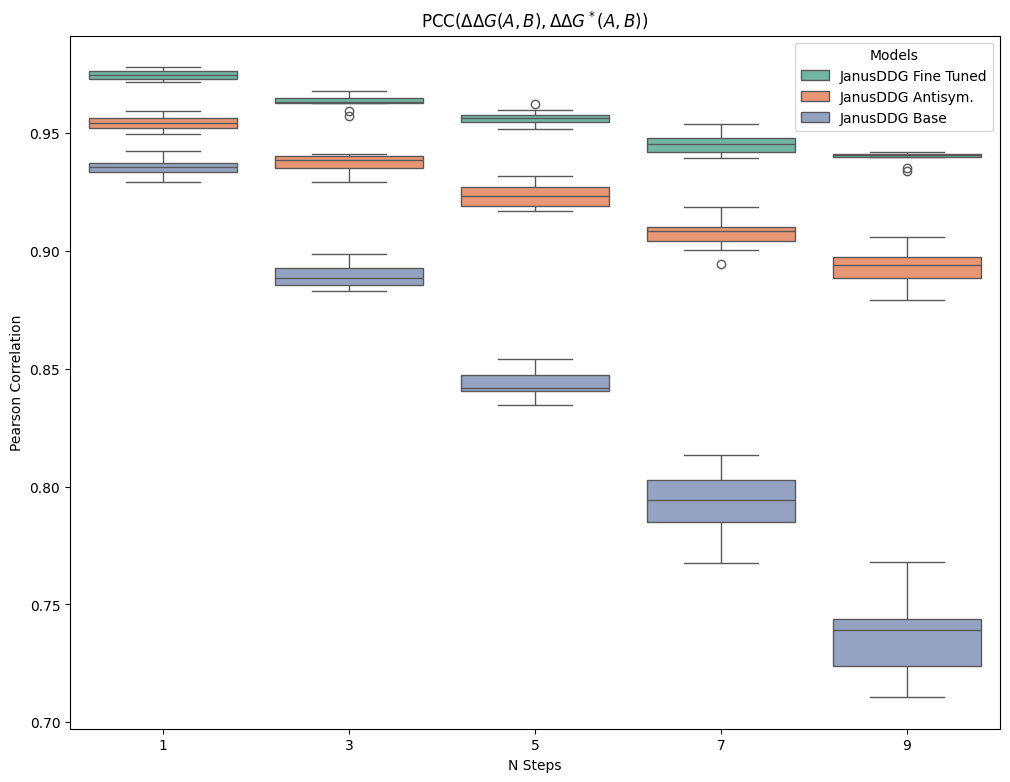

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Funzione per calcolare le correlazioni e preparare i dati
def calculate_correlations(files, df0_file, label_prefix):
    dfs = [pd.read_csv(f) for f in files]
    correlations_list = []  # Lista per tutte le correlazioni
    df_labels = []  # Lista per etichettare i dataframe
    group_labels = []  # Lista per etichettare il gruppo (JANUS o BASEANTY)

    # Carica il dataframe df0
    df0 = pd.read_csv(df0_file)

    # Verifica che la colonna '0' esista in df0
    if '0' not in df0.columns:
        raise ValueError(f"La colonna '0' non esiste in {df0_file}!")

    # Calcolare le correlazioni
    for df, num in zip(dfs, range(1, 10, 2)):
        for col in df.columns[1:]:  # Escludiamo la prima colonna (indice)
            corr = df[col].corr(df0['0'])  # Calcolare la correlazione di Pearson
            correlations_list.append(corr)  # Aggiungi la correlazione alla lista
            df_labels.append(num)  # Etichetta il dataframe con il suo numero
            group_labels.append(label_prefix)  # Aggiungi il gruppo (JANUS o BASEANTY)

    return correlations_list, df_labels, group_labels

# Elenco dei file e calcolo per i dataframe JANUS
files_janus = [f's669_DDGjanus_FINALE_TRANSITIVITY_N{i}.csv' for i in range(1, 10, 2)]
df0_janus = 's669_DDGjanus_FINALE_TRANSITIVITY_N0.csv'
correlations_janus, df_labels_janus, group_labels_janus = calculate_correlations(files_janus, df0_janus, 'JanusDDG Fine Tuned')

# Elenco dei file e calcolo per i dataframe BASEANTY
files_baseanty = [f's669_DDGjanusBASEANTY_TRANSITIVITY_N{i}.csv' for i in range(1, 10, 2)]
df0_baseanty = 's669_DDGjanusBASEANTY_TRANSITIVITY_N0.csv'
correlations_baseanty, df_labels_baseanty, group_labels_baseanty = calculate_correlations(files_baseanty, df0_baseanty, 'JanusDDG Antisym.')

# Elenco dei file e calcolo per i dataframe BASEANTY
files_base = [f's669_DDGjanusBASE_TRANSITIVITY_N{i}.csv' for i in range(1, 10, 2)]
df0_base = 's669_DDGjanusBASE_TRANSITIVITY_N0.csv'
correlations_base, df_labels_base, group_labels_base = calculate_correlations(files_base, df0_base, 'JanusDDG Base')

# Combina i dati di entrambe le categorie
correlations_list = correlations_janus + correlations_baseanty +correlations_base
df_labels_combined = df_labels_janus + df_labels_baseanty + df_labels_base
group_labels_combined = group_labels_janus + group_labels_baseanty + group_labels_base

# Creare un box plot delle correlazioni
plt.figure(figsize=(12, 9))
sns.boxplot(x=df_labels_combined, y=correlations_list, hue=group_labels_combined, palette="Set2", dodge=False)
plt.title(r'PCC($\Delta\Delta G), \Delta\Delta G^*$)')
plt.xlabel('N Steps')
plt.ylabel('Pearson Correlation')

# Impostiamo le etichette x senza inclinazione
plt.xticks(rotation=0)  # Manteniamo le etichette x orizzontali
plt.legend(title="Models", loc='upper right')
plt.show()


/tmp/ipykernel_269817/3444429082.py:53: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x=df_labels_combined, y=correlations_list, hue=group_labels_combined, palette=custom_palette, dodge=False)


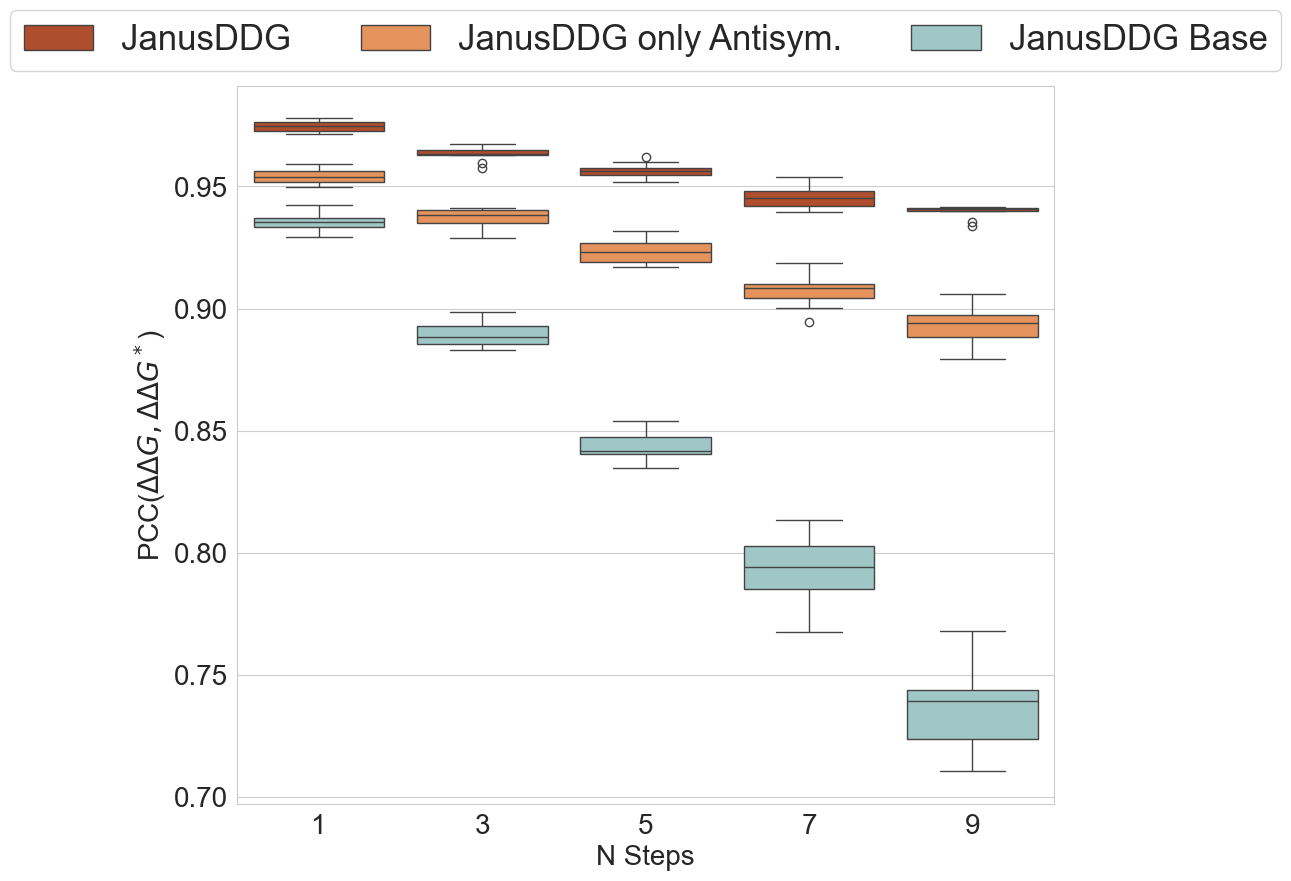

In [85]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Imposta lo stile per un aspetto pulito e professionale
sns.set_style("whitegrid")
plt.rcParams.update({'font.size': 14})  # Aumenta la dimensione del font

# Funzione per calcolare le correlazioni e preparare i dati
def calculate_correlations(files, df0_file, label_prefix):
    dfs = [pd.read_csv(f) for f in files]
    correlations_list = []  
    df_labels = []  
    group_labels = []  

    df0 = pd.read_csv(df0_file)

    if '0' not in df0.columns:
        raise ValueError(f"La colonna '0' non esiste in {df0_file}!")

    for df, num in zip(dfs, range(1, 10, 2)):
        for col in df.columns[1:]:  
            corr = df[col].corr(df0['0'])  
            correlations_list.append(corr)  
            df_labels.append(num)  
            group_labels.append(label_prefix)  

    return correlations_list, df_labels, group_labels

# Caricamento dati
files_janus = [f's669_DDGjanus_FINALE_TRANSITIVITY_N{i}.csv' for i in range(1, 10, 2)]
df0_janus = 's669_DDGjanus_FINALE_TRANSITIVITY_N0.csv'
correlations_janus, df_labels_janus, group_labels_janus = calculate_correlations(files_janus, df0_janus, 'JanusDDG')

files_baseanty = [f's669_DDGjanusBASEANTY_TRANSITIVITY_N{i}.csv' for i in range(1, 10, 2)]
df0_baseanty = 's669_DDGjanusBASEANTY_TRANSITIVITY_N0.csv'
correlations_baseanty, df_labels_baseanty, group_labels_baseanty = calculate_correlations(files_baseanty, df0_baseanty, 'JanusDDG only Antisym.')

files_base = [f's669_DDGjanusBASE_TRANSITIVITY_N{i}.csv' for i in range(1, 10, 2)]
df0_base = 's669_DDGjanusBASE_TRANSITIVITY_N0.csv'
correlations_base, df_labels_base, group_labels_base = calculate_correlations(files_base, df0_base, 'JanusDDG Base')

# Combina i dati
correlations_list = correlations_janus + correlations_baseanty + correlations_base
df_labels_combined = df_labels_janus + df_labels_baseanty + df_labels_base
group_labels_combined = group_labels_janus + group_labels_baseanty + group_labels_base

# Palette personalizzata
custom_palette = ["#C4421A", "#F98F45", "#97CECC", "#12908E"]

# Creazione del grafico
plt.figure(figsize=(12, 9))
sns.boxplot(x=df_labels_combined, y=correlations_list, hue=group_labels_combined, palette=custom_palette, dodge=False)

# Miglioramenti grafici
#plt.title(r'PCC($\mathbf{\Delta\Delta G(A,B), \Delta\Delta G^*(A,B)}$)', fontsize=16, fontweight='bold')
plt.xlabel('N Steps', fontsize=20)
plt.ylabel(r'PCC($\Delta\Delta G, \Delta\Delta G^*$)', fontsize=20)
plt.xticks(rotation=0,fontsize=20)  # Mantieni le etichette orizzontali
plt.yticks(rotation=0,fontsize=20)  # Mantieni le etichette orizzontali

# Miglioramento della legenda
#plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,fontsize=18)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, fontsize=25)
# Ottimizza la disposizione degli elementi
plt.tight_layout()

# Mostra il grafico
plt.show()


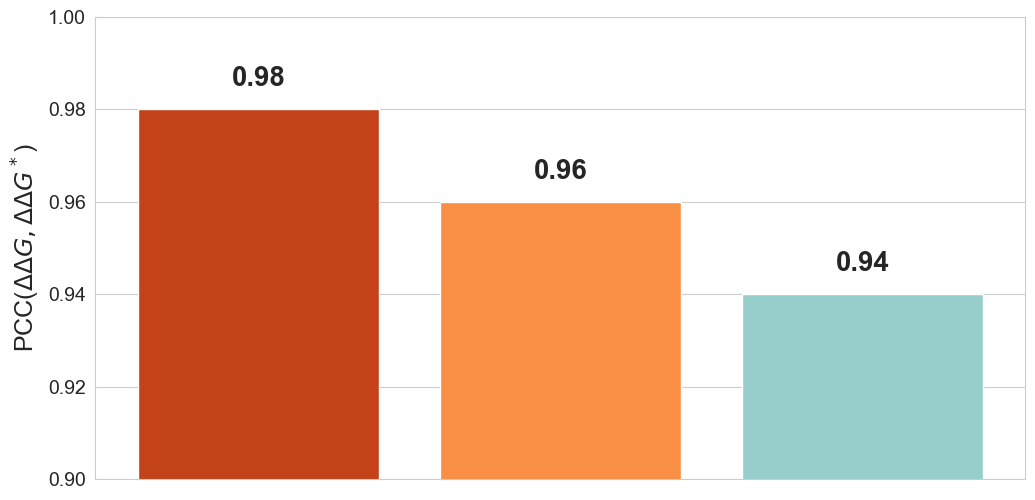

In [82]:


import matplotlib.pyplot as plt
import seaborn as sns

# Dati
models = ['JanusDDG Fine Tuned', 'JanusDDG Antisym.', 'JanusDDG Base']
values = [0.98, 0.96, 0.94]  # Valori del Pearson
palette = ['#C4421A', '#F98F45', '#97CECC']  # Stessa palette

# Creazione del bar plot
plt.figure(figsize=(12, 6))
bars = plt.bar(range(len(values)), values, color=palette)

# Titolo e etichette
#plt.title(r'Pearson Correlation between $\Delta\Delta G$ and $\Delta\Delta G^*$', fontsize=14, fontweight='bold')
plt.ylabel(r'PCC($\Delta\Delta G, \Delta\Delta G^*$)', fontsize=18)
plt.xticks([])  # Rimuove le etichette dell'asse X

# Aggiunta della legenda
#plt.legend(bars, models, loc="upper right", fontsize=10, bbox_to_anchor=(1.2, 1.10))

# Impostiamo i limiti dell'asse Y per migliore leggibilità
plt.ylim(0.9, 1.0)

# Rendi più visibili i valori sopra le barre
for i, v in enumerate(values):
    plt.text(i, v + 0.005, f"{v:.2f}", ha='center', fontsize=20, fontweight='bold')

# Mostra il grafico
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Supponiamo che i tuoi dataframe siano già caricati in queste variabili:
# df1, df3, df5, df7, df9, df0

# Elenco dei dataframe
dfs = [pd.read_csv(f's669_DDGjanus_FINALE_TRANSITIVITY_N{i}.csv') for i in range(1,10,2)]
correlations = []

# Calcolare la correlazione di Pearson tra ogni colonna dei dataframe (df1, df3, ..., df9)
# e l'unica colonna di df0 (assumiamo che df0 abbia una sola colonna)
df0 = pd.read_csv('s669_DDGjanus_FINALE_TRANSITIVITY_N0.csv')  # Nome della colonna di df0

for df in dfs:
    for col in df.columns[1:]:
        # Calcolare la correlazione di Pearson
        corr = df[col].corr(df0['0'])
        correlations.append(corr)

# Creare un box plot delle correlazioni
plt.figure(figsize=(10, 6))
sns.boxplot(data=correlations)
plt.title('Distribuzione delle correlazioni di Pearson')
plt.ylabel('Correlazione')
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Lista dei valori di N
N_values = [1, 3, 5, 7,9]

# Lista per memorizzare i dati di Pearson per ogni file
data = []
data_naive=[]

pred_N0 = pd.read_csv('s669_DDGjanus_FINALE_TRANSITIVITY_N0.csv')

# Carica i file pickle
for N in N_values:
    # Carica il dataframe da file pickle
    df = pd.read_pickle(f'transitivity_results/pearson_TransJanusDDG_N{N}.pkl')
    
    # Aggiungi una colonna con il valore di N (in modo che i valori possano essere tracciati nel boxplot)
    df['N'] = N
    
    # Aggiungi i risultati nel data list
    data.append(df)

N_values = [1, 3,5,7,9]

# Carica i file pickle
for N in N_values:
    # Carica il dataframe da file pickle
    df = pd.read_pickle(f'transitivity_results/pearson_JanusDDG_N{N}.pkl')
    
    # Aggiungi una colonna con il valore di N (in modo che i valori possano essere tracciati nel boxplot)
    df['N'] = N
    
    # Aggiungi i risultati nel data list
    data_naive.append(df)

# Unisci tutti i dataframe in un unico dataframe
df_all = pd.concat(data)
df_naive_all = pd.concat(data_naive)

# Imposta il grafico
plt.figure(figsize=(8, 6))
sns.boxplot(x='N', y='statistic', data=df_all, label='JanusDDG Fine Tuned')

sns.boxplot(x='N', y='statistic', data=df_naive_all, label='JanusDDG')

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Legenda con font più grande
plt.legend(fontsize=16)

# Etichetta gli assi
plt.xlabel('N Steps',fontsize=16)
plt.ylabel('Pearson Correlation',fontsize=16)

# Mostra il grafico
#plt.title('Boxplot of Pearson Correlation for Different N')
plt.show()


In [ ]:
data_naive

In [ ]:
assert False

In [ ]:

# all_predictions_test_dir.to_pickle(f's669_Hydra_25transit_0_step_dir.pkl')
# all_predictions_test_inv.to_pickle(f's669_Hydra_25transit_0_step_inv.pkl')

In [ ]:
plt.hist(all_predictions_test_dir,bins=50)

In [ ]:
#all_predictions_test_inv.to_pickle('pred_cdna117k_inv_janus.pkl')

In [ ]:
metrics((all_predictions_test_dir-all_predictions_test_inv)/2,-(all_predictions_test_dir-all_predictions_test_inv)/2, all_lables_test_dir)

In [ ]:
metrics(all_predictions_test_dir,all_predictions_test_inv, all_lables_test_dir)

In [ ]:
pearson = []

step_0_dir = pd.read_pickle(f's669_Hydra_25transit_0_step_dir.pkl').values
step_0_inv = pd.read_pickle(f's669_Hydra_25transit_0_step_inv.pkl').values

for i in range(2,11):
    dir = pd.read_pickle(f's669_Hydra_25transit_{i}_step_dir.pkl').values
    inv = pd.read_pickle(f's669_Hydra_25transit_{i}_step_inv.pkl').values
    pearson.append(pearsonr((step_0_dir-step_0_inv)/2,(dir-inv)/2)[0])

In [ ]:
pearson

In [ ]:
#pearsonr(pd.read_pickle(f's669_Hydra_4_step_dir.pkl').values, step_0_dir)

In [ ]:
pearson_2 = []

step_0_dir = pd.read_pickle(f's669_Hydra_0_step_dir.pkl').values
step_0_inv = pd.read_pickle(f's669_Hydra_0_step_inv.pkl').values

for i in range(2,11):
    dir = pd.read_pickle(f's669_Hydra_{i}_step_dir.pkl').values
    inv = pd.read_pickle(f's669_Hydra_{i}_step_inv.pkl').values
    pearson_2.append(pearsonr((step_0_dir-step_0_inv)/2,(dir-inv)/2)[0])

In [ ]:
pearson_2

In [ ]:
sns.scatterplot(x=[i for i in range(2,11)],y=pearson_2, label='JanusDDG')
plt.xlabel('N Steps')
plt.ylabel('Pearson Correlation')
sns.scatterplot(x=[i for i in range(2,11)],y=pearson, label='JanusDDG Fine Tuned')
plt.xlabel('N Steps')
plt.ylabel('Pearson Correlation')

In [ ]:
assert False

In [ ]:
df_ordinati = pd.read_pickle('indici_ordinati_s669.pkl')
df_ordinati = df_ordinati.sort_values(by='index_castrense')
df_ordinati

df_to_piero = df_ordinati.loc[:,[0, 1,'DDG']]
df_to_piero = df_to_piero.rename(columns={0:'PDB', 1:'MUT'})
df_to_piero['CHAIN'] = df_to_piero['PDB'].map(lambda x: x[-1])
df_to_piero['PDB'] = df_to_piero['PDB'].map(lambda x: x[:-1])

df_to_piero = df_to_piero.loc[:,['PDB','CHAIN','MUT','DDG']]
df_to_piero['DDG_PRED']=all_predictions_test_dir.values

df_to_piero
pearsonr(df_to_piero['DDG'].values,df_to_piero['DDG_PRED'].values )
df_to_piero.to_csv('Dataset_s669_pred_X_Piero.csv')

In [ ]:
df_to_piero.loc[665,:]

In [ ]:
# df = pd.read_pickle('df_mapping_s2450_s2648.pkl')
# df = df.sort_values(by='index_cas')
# df['DDG_PRED']= all_predictions_test_dir.values
# df = df[['PDB','CHAIN',	'MUT',	'DDG', 'DDG_PRED']]
# df.to_csv('Dataset_s2450_pred_X_Piero.csv')

In [ ]:
pd.read_excel('TS1.xlsx',header=1).iloc[2483:,]

In [ ]:
assert False

#studio distanza e doppie

In [ ]:
df = pd.DataFrame({
    "Predictions": -all_predictions_test_dir.values.flatten(),
    "Labels": all_lables_test_dir.values.flatten(),
    "Distance": np.array([np.abs(i[0][0][1] - i[0][0][0]).item() for i in p_dir])
})

df


In [ ]:
plt.hist(df['Distance'].values, bins=50)

In [ ]:
pearson_and_dist = []
num_samples= []

for dist in range(3,100,1):
    df_dist = df[df['Distance']<dist]
    num_samples.append(df_dist.shape[0]/df.shape[0])

    pearson_and_dist.append(pearsonr(df_dist['Predictions'].values,df_dist['Labels'].values)[0])

plt.plot(pearson_and_dist)
#plt.plot(num_samples)
#plt.yscale('log')

In [ ]:
pearson_and_dist = []
num_samples= []
for dist in range(2,80,1):
    df_dist = df[df['Distance']>dist]
    num_samples.append(df_dist.shape[0]/df.shape[0])
    pearson_and_dist.append(pearsonr(df_dist['Predictions'].values,df_dist['Labels'].values)[0])

plt.plot(pearson_and_dist)
#plt.plot(num_samples)

In [ ]:
pearson_and_dist = []
num_samples= []
for dist in range(10,100,1):
    df_dist = df[(df['Distance'] > dist- 10) & (df['Distance'] < (dist + 10))]
    num_samples.append(df_dist.shape[0]/df.shape[0])
    pearson_and_dist.append(pearsonr(df_dist['Predictions'].values,df_dist['Labels'].values)[0])

plt.plot(pearson_and_dist)
#plt.plot(num_samples)

In [ ]:
assert False

In [ ]:
all_predictions_test, all_lables_test = model_performance_test(best_model,dataloader_test,
                                                          inv=False, train=False)

In [ ]:
print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(),torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(),torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
pearsonr(torch.cat(all_predictions_test, dim=0).cpu()[:669],torch.cat(all_predictions_test, dim=0).cpu()[669:])

In [ ]:
(torch.cat(all_predictions_test, dim=0).cpu()[:669] + torch.cat(all_predictions_test, dim=0).cpu()[669:]).mean()

In [ ]:
#pd.Series(torch.cat(all_predictions_test, dim=0).cpu()).to_pickle('DDGemb_cross_0_predictions.pkl')

In [ ]:
pd.read_pickle('indici_ordinati_s669.pkl').sort_values(by='index_castrense')['DDG'].values

In [ ]:
indici_ordinati = pd.read_pickle('indici_ordinati_s669.pkl').sort_values(by='index_castrense')['index'].values
pythia_s669 = pd.read_csv('../DeltaDeltaG/pythia_s669.csv').iloc[indici_ordinati,:]['Pythia_inv']
info_mut = pd.read_csv('../DeltaDeltaG/pythia_s669.csv').iloc[indici_ordinati,:][['wildtype','mutation']]
pred_janus= np.array(torch.cat(all_predictions_test, dim=0).cpu())
true_ddg = pd.read_pickle('indici_ordinati_s669.pkl').sort_values(by='index_castrense')['DDG'].values#np.array(torch.cat(all_lables_test, dim=0).cpu())

df = pd.DataFrame({
    'wild':info_mut.iloc[:,0].values,
    'mut':info_mut.iloc[:,1].values,
    'pythia_s669': pythia_s669.values,  # Deve avere la stessa lunghezza di predictions
    'predictions': pred_janus,  # Ogni riga avrà un valore scalare o un array se multidimensionale
    'true_ddg':true_ddg
})
df.index = indici_ordinati
print('Pearson s669: ', pearsonr(df['predictions'],df['true_ddg']))   


indici_ordinati_s461  = pd.read_pickle('indici_ordinati_s669.pkl').dropna(subset='s461_pdb').sort_values(by='index_castrense')['index'].values



In [ ]:
rose_csv = pd.read_csv('rose1985.csv')

def rose_score(row):
    wild_rose = rose_csv[rose_csv['Parameter']==row['wild']]['Rose1985'].values[0]
    mut_rose = rose_csv[rose_csv['Parameter']==row['mut']]['Rose1985'].values[0]
    return wild_rose - mut_rose
    
df['Rose'] = df.apply(rose_score,axis=1)
df

In [ ]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression(fit_intercept=False)

lr.fit(df[['pythia_s669','Rose']].values,df['true_ddg'].values)
pearsonr(lr.predict(df[['pythia_s669','Rose']].values),df['true_ddg'].values)



In [ ]:
pearsonr(df['pythia_s669'].values * 0.11 - df['Rose'].values*0.0088,df['true_ddg'].values)


In [ ]:
df_s461 = df.loc[indici_ordinati_s461,:]

In [ ]:
print(pearsonr(df_s461['pythia_s669']*0.11-df_s461['Rose']*0.0088 ,df_s461['true_ddg']))   
print(pearsonr(df_s461['predictions'],df_s461['true_ddg']))   
print('RMSE: ', root_mean_squared_error(df_s461['pythia_s669'],df_s461['true_ddg']))
print('MAE: ', mean_squared_error(df_s461['pythia_s669'],df_s461['true_ddg']))



In [ ]:
df

In [ ]:
print(pearsonr(df_s461['predictions'],df_s461['true_ddg']))   
print(pearsonr(df['predictions'],df['true_ddg']))   


In [ ]:
print(f'Pearson test dirette: {pearsonr(-0.07416111+ pythia_s669.values*0.09+np.array(torch.cat(all_predictions_test, dim=0).cpu()*0.57), torch.cat(all_lables_test, dim=0).cpu())}')   


In [ ]:
pd.Series(torch.cat(all_predictions_test, dim=0).cpu()).to_pickle('Janus_s669_fake.pkl')

In [ ]:
dir = torch.cat(all_predictions_test, dim=0).cpu()

In [ ]:
inv = torch.cat(all_predictions_test, dim=0).cpu()


In [ ]:
tot =(dir-inv) /2

In [ ]:
tot

In [ ]:
metrics( pd.DataFrame(tot),  pd.DataFrame(tot), pd.DataFrame(torch.cat(all_lables_test, dim=0).cpu()))

In [ ]:
pred_inv = all_predictions_test

In [ ]:
pred_dirette = all_predictions_test
true = all_lables_test

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

metrics( pd.DataFrame(torch.cat(pred_dirette, dim=0).cpu()), pd.DataFrame(torch.cat(pred_inv, dim=0).cpu()), pd.DataFrame(torch.cat(true, dim=0).cpu()))

In [ ]:
50+49+53+51+51

In [ ]:
for i in range(5):
    val_Set = [0,1,2,3,4]
    val_Set.remove(i)
    print(val_Set)
    best_model = torch.load(f'DDGemb_Cross_{i}.pth')
    
    dataloader_val = dataloader_generation_pred(E_TYPE,  test_path=[f's2450_fold_{i}.pkl']+[f's2450_fold_{i}_inv.pkl'],
                                                 batch_size = 6, dataloader_shuffle = False, inv= False)
    
    all_predictions_val, all_lables_val = model_performance_test(best_model,dataloader_val,
                                                              inv=False, train=False)
    
    
    print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_val, dim=0).cpu(), torch.cat(all_lables_val, dim=0).cpu())}')   


In [ ]:
pesi = np.array([0.2,0.21,0.2,0.19,0.2])

In [ ]:
pred_tot = []

for i in range(5):
    best_model = torch.load(f'DDGemb_Cross_{i}.pth')
    
    all_predictions_test, all_lables_test = model_performance_test(best_model,dataloader_test,
                                                          inv=False, train=False)
    
    pred_tot.append(pd.Series(torch.cat(all_predictions_test, dim=0).cpu()))#.to_pickle('DDGemb_Cross_0_predictions_s669.pkl')

In [ ]:
pred_inv = pred_tot.copy()

In [ ]:
pred_dir = pred_tot.copy()

In [ ]:
pred_tot

In [ ]:
somma_pesata_dir = sum(w * v for w, v in zip(pesi, pred_tot))

print(somma_pesata)

In [ ]:
pesi

In [ ]:
somma_pesata_inv = sum(w * v for w, v in zip(pesi, pred_inv))


In [ ]:
r = pred_tot[0]+pred_tot[1]+pred_tot[2]+pred_tot[3]+pred_tot[4]

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test dirette: {pearsonr(somma_pesata, torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'Spearmanr test dirette: {spearmanr(somma_pesata, torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(somma_pesata, torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(somma_pesata, torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
somma_pesata

In [ ]:
somma_pesata_inv

In [ ]:
metrics(pd.DataFrame(somma_pesata_dir),pd.DataFrame(somma_pesata_inv),-pd.DataFrame(torch.cat(all_lables_test, dim=0).cpu()))

In [ ]:
np.mean([386,342,187,497,105])

In [ ]:
best_model = torch.load(f'DDGemb_Cross_4.pth')
all_predictions_test, all_lables_test = model_performance(best_model,dataloader_test,
                                                          dataloader_train=None,dataloader_validation=None,inv=True, train=False)

pred_tot.append(pd.Series(torch.cat(all_predictions_test, dim=0).cpu()))#.to_pickle('DDGemb_Cross_0_predictions_s669.pkl')

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'Spearmanr test dirette: {spearmanr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
#BOOTSTRAPPING

results_naive=[]
for i in range(1000):
    dataloader_test = dataloader_generation_pred(E_TYPE,  test_path='ddg_s669_ESM2_HYDRA_LITE.pkl',  batch_size = 128, dataloader_shuffle = False, inv= False)

    all_predictions_test, all_lables_test = model_performance(best_model,
                                                                                                                                           dataloader_test,
                                                                                                                                           dataloader_train=None,
                                                                                                                                           dataloader_validation=None,         
                                                                                                                                           inv=False,
                                                                                                                                           train=True)
    results_naive.append(pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())[0]) 

pd.DataFrame(results_naive).to_pickle('result_bootstrapping_MLP_27_01_2025.pkl')

In [ ]:
best_model = torch.load('MLP_HYDRA_MEAN_29_01_2025.pth')#('MLP_HYDRA_MEAN_29_01_2025.pth')#'MLP_27_01_2025.pth')#('MPL_HYDRA_model_7W_256_256.pth')
best_model.hydra=True
results_hydra=[]
for i in range(1000):
    dataloader_test = dataloader_generation_pred(E_TYPE,  test_path='ddg_s669_ESM2_HYDRA_LITE.pkl',  batch_size = 128, dataloader_shuffle = False, inv= False)

    all_predictions_test, all_lables_test = model_performance(best_model,
                                                                                                                                           dataloader_test,
                                                                                                                                           dataloader_train=None,
                                                                                                                                           dataloader_validation=None,         
                                                                                                                                           inv=False,
                                                                                                                                           train=True)
    results_hydra.append(pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())[0]) 

pd.DataFrame(results_hydra).to_pickle('result_bootstrapping_MLP_HYDRA_MEAN_29_01_2025.pkl')

In [ ]:
sns.histplot(results_hydra,kde=True,color='blue')
sns.histplot(results_naive,kde=True,color='red')
from scipy.stats import ks_2samp
ks_2samp(results_hydra,results_naive)

In [ ]:
sns.histplot(results_hydra,kde=True)
sns.histplot(results_naive,kde=True)
from scipy.stats import ks_2samp
ks_2samp(results_hydra,results_naive)

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'Spearmanr test dirette: {spearmanr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
pd.Series(torch.cat(all_predictions_test, dim=0).cpu())

In [ ]:
#pd.Series(torch.cat(all_predictions_train, dim=0).cpu()).to_pickle('MLP_HYDRA_7W_256_256_predictions_esm2_train.pkl')
pd.Series(torch.cat(all_predictions_test, dim=0).cpu()).to_pickle('MLP_HYDRA_MEAN_29_01_2025.pkl')
#pd.Series(torch.cat(all_predictions_validation, dim=0).cpu()).to_pickle('MLP_HYDRA_7W_256_256_predictions_esm2_val.pkl')
# pd.Series(torch.cat(all_lables_train, dim=0).cpu()).to_pickle('MLP_all_lables_train.pkl')
# pd.Series(torch.cat(all_lables_test, dim=0).cpu()).to_pickle('MLP_all_lables_test.pkl')
# pd.Series(torch.cat(all_lables_validation, dim=0).cpu()).to_pickle('MLP_all_lables_val.pkl')

In [ ]:
#####NOMI 
#'MLP_HYDRA_7W_256_256_predictions_esm2_train.pkl'


#####

In [ ]:
pd.Series(torch.cat(all_predictions_test, dim=0).cpu()).to_pickle('MLP_HYDRA_7W_256_256_predictions_Protherm_Doubles_pdbnum_2.pkl')


In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test d-r: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_predictions_test_inv, dim=0).cpu())}') 

In [ ]:
from sklearn.metrics import root_mean_squared_error,mean_absolute_error

print(f'Pearson test dirette: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')   
print(f'Spearmanr test dirette: {spearmanr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')


# Pearson test dirette: PearsonRResult(statistic=0.49811210357961794, pvalue=3.0676935334080987e-43)
# Pearson test dirette: SignificanceResult(statistic=0.5209411003368696, pvalue=8.229743816346383e-48)
# RMSE dirette: 1.4306520223617554
# MAE dirette: 1.0020039081573486

# Pearson test dirette: PearsonRResult(statistic=0.4984754880369162, pvalue=2.6104865839652876e-43)
# Pearson test dirette: SignificanceResult(statistic=0.5219817530960136, pvalue=4.996030095808217e-48)
# RMSE dirette: 1.4335042238235474
# MAE dirette: 1.0032145977020264

In [ ]:
print(f'Pearson test dirette: {spearmanr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
print(f'Pearson test inverse: {pearsonr(torch.cat(all_predictions_test_inv, dim=0).cpu(), torch.cat(all_lables_test_inv, dim=0).cpu())}')    
print(f'RMSE inve: {root_mean_squared_error(torch.cat(all_predictions_test_inv, dim=0).cpu(), torch.cat(all_lables_test_inv, dim=0).cpu())}')
print(f'MAE inve: {mean_absolute_error(torch.cat(all_predictions_test_inv, dim=0).cpu(), torch.cat(all_lables_test_inv, dim=0).cpu())}')

In [ ]:
all_predictions_test.extend(all_predictions_test_inv)
all_lables_test.extend(all_lables_test_inv)
print(f'Pearson test dirette+inverse: {pearsonr(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')    
print(f'RMSE dirette+inverse: {root_mean_squared_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')
print(f'MAE dirette+inverse: {mean_absolute_error(torch.cat(all_predictions_test, dim=0).cpu(), torch.cat(all_lables_test, dim=0).cpu())}')

In [ ]:
all_predictions_test

In [ ]:
## 

In [ ]:
y_esm2_train = pd.read_pickle('MLP_all_predictions_esm2_s2648.pkl')
y_esm2_test = pd.read_pickle('MLP_all_predictions_esm2_s669.pkl')

y_ohe_train = pd.read_pickle('MLP_all_predictions_ohe_s2648.pkl')
y_ohe_test = pd.read_pickle('MLP_all_predictions_ohe_s669.pkl')

y_true_test = pd.DataFrame(torch.cat(all_lables_test, dim=0).cpu())
y_true_train = pd.DataFrame(torch.cat(all_lables_train, dim=0).cpu())

In [ ]:
from sklearn.linear_model import LinearRegression

X_train = pd.concat([y_esm2_train,y_ohe_train],axis=1)
X_test = pd.concat([y_esm2_test,y_ohe_test],axis=1) 
y_train = y_true_train

lr = LinearRegression()
lr.fit(X_train, y_train)
prediction_lr = lr.predict(X_test)

In [ ]:
prediction_lr.reshape(669).values.shape

In [ ]:
y_true_test

In [ ]:
# Assicurati che entrambe le variabili siano monodimensionali
y_true_test_flat = y_true_test.values.ravel()  # Oppure .flatten()
prediction_lr_flat = prediction_lr.reshape(669).ravel()  # Oppure np.squeeze()

print(f'Pearson test dirette: {pearsonr(y_true_test_flat, prediction_lr_flat)}')    
print(f'RMSE dirette: {root_mean_squared_error(y_true_test_flat, prediction_lr_flat)}')  
print(f'MAE dirette: {mean_absolute_error(y_true_test_flat, prediction_lr_flat)}')  

In [ ]:
print(f'Pearson test dirette: {pearsonr(y_true_test_flat, X_test.iloc[:,0])}')    
print(f'RMSE dirette: {root_mean_squared_error(y_true_test_flat, X_test.iloc[:,0])}')  
print(f'MAE dirette: {mean_absolute_error(y_true_test_flat, X_test.iloc[:,0])}')  

In [ ]:
#################FINE

In [ ]:
with open('ddg_s2648_ESM2.pkl', 'rb') as f:
    dataset_s2648 = pickle.load(f)

with open('ddg_s669_ESM2.pkl', 'rb') as f:
    dataset_s669 = pickle.load(f)

In [ ]:

# # Creiamo il dataset
dataset_train = ProteinDataset(dataset_s2648, threshold=5.0)
dataset_test = ProteinDataset(dataset_s669, threshold=5.0)


# Creazione di un DataLoader
dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=32, shuffle=False)

In [ ]:
dic_embedding_aa = {}
ordine_aa = {}

aa_a = "ACDEFGHIKLMNPQRSTVWY"

ind_pos = 0
for name_aa in [*aa_a]:
    dic_embedding_aa[name_aa] = np.zeros(20)
    dic_embedding_aa[name_aa][ind_pos] = 1

    ordine_aa[name_aa] = ind_pos

    ind_pos+=1


In [ ]:
info_letters_test = []
info_letters_train = []
info_mutation_test = []
info_mutation_train = []

for batch in dataloader_test:
    info_letters_test = []
    
    for batch_i in range(len(batch['id'])):
        vector_w = [1 if i == 1 else 0 for i in batch['V'][batch_i][:]]
        vector_m = [1 if i == -1 else 0 for i in batch['V'][batch_i][:]]
        letter_w = next((k for k, v in dic_embedding_aa.items() if (v == vector_w).all()), None)
        letter_m = next((k for k, v in dic_embedding_aa.items() if (v == vector_m).all()), None)
        letters = [letter_w + letter_m]
        info_letters_test.extend(letters)

    info_mutation_test.extend([id+l[0]+str(pos)+l[-1] for id, pos, l in zip(batch['id'],batch['position'].tolist(), info_letters_test)])
    

for batch in dataloader_train:
    info_letters_train = []
    for batch_i in range(len(batch['id'])):
        vector_w = [1 if i == 1 else 0 for i in batch['V'][batch_i][:]]
        vector_m = [1 if i == -1 else 0 for i in batch['V'][batch_i][:]]
        letter_w = next((k for k, v in dic_embedding_aa.items() if (v == vector_w).all()), None)
        letter_m = next((k for k, v in dic_embedding_aa.items() if (v == vector_m).all()), None)
        letters = [letter_w + letter_m]
        info_letters_train.extend(letters)

    info_mutation_train.extend([id+l[0]+str(pos)+l[-1] for id, pos, l in zip(batch['id'],batch['position'].tolist(), info_letters_train)])



In [ ]:
len(info_mutation_train)

In [ ]:
# Assicurati che il modello sia in modalità di valutazione
DDG_model.eval()

# Lista per salvare tutte le predizioni
all_predictions_test = []
all_predictions_train = []

all_lables_train = []
all_lables_test = []

with torch.no_grad():  # Disable gradient calculation
    for i, batch in enumerate(dataloader_test):
        graph_x = batch.x.float().to(device)   #wild_type
        graph_edge_index = batch.edge_index.to(device)   #wild_type
        graph_batch = batch.batch.to(device)   #wild_type
        labels = batch.y.float().float().to(device)
        position_wild = position_adj(batch.position, batch.ptr)
        position_mut = position_mut_adj(batch.position, batch.ptr)
        intervallo_wild = edge_index_wild(graph_x, batch.ptr)
        intervallo_mut = edge_index_mut(graph_x, batch.ptr)
        V = batch.V
        edge_weights = batch.edge_weight
        predictions = DDG_model(graph_x, graph_edge_index, labels,position_wild,position_mut, V,
                        edge_weights = edge_weights,intervallo_wild= intervallo_wild,intervallo_mut =intervallo_mut)  
            
        all_predictions_test.append(predictions)
        all_lables_test.append(labels)


with torch.no_grad():  # Disable gradient calculation
    for i, batch in enumerate(dataloader_train):
        graph_x = batch.x.float().to(device)   #wild_type
        graph_edge_index = batch.edge_index.to(device)   #wild_type
        graph_batch = batch.batch.to(device)   #wild_type
        labels = batch.y.float().float().to(device)
        position_wild = position_adj(batch.position, batch.ptr)
        position_mut = position_mut_adj(batch.position, batch.ptr)
        intervallo_wild = edge_index_wild(graph_x, batch.ptr)
        intervallo_mut = edge_index_mut(graph_x, batch.ptr)
        V = batch.V
        edge_weights = batch.edge_weight
        predictions = DDG_model(graph_x, graph_edge_index, labels,position_wild,position_mut, V,
                        edge_weights = edge_weights,intervallo_wild= intervallo_wild,intervallo_mut =intervallo_mut) 

        
        # Aggiungi le predizioni alla lista
        all_predictions_train.append(predictions)
        all_lables_train.append(labels)


In [ ]:
all_predictions_test = torch.cat([i[0] for i in all_predictions_test], dim=0)
all_predictions_train = torch.cat([i[0] for i in all_predictions_train], dim=0)

In [ ]:
all_predictions_train_dir = all_predictions_train[:int(all_predictions_train.shape[0]/2)]
all_predictions_train_inv = all_predictions_train[int(all_predictions_train.shape[0]/2):]

In [ ]:
all_predictions_test_dir = all_predictions_test[:int(all_predictions_test.shape[0]/2)]
all_predictions_test_inv = all_predictions_test[int(all_predictions_test.shape[0]/2):]

In [ ]:
from scipy.stats import pearsonr
pearsonr(all_predictions_test_dir.cpu(),all_predictions_test_inv.cpu())

In [ ]:
from scipy.stats import pearsonr
pearsonr(all_predictions_train.cpu(),torch.cat(all_lables_train, dim=0).cpu())

In [ ]:
prediction_guido_test = pd.DataFrame(np.array([info_mutation_test, all_predictions_test.cpu().numpy()]).T)
prediction_guido_train = pd.DataFrame(np.array([info_mutation_train, all_predictions_train.cpu().numpy()]).T)

In [ ]:
prediction_guido_train.drop_duplicates(subset=[0])

In [ ]:
prediction_guido_train.iloc[:,1] = prediction_guido_train.iloc[:,1].map(lambda x: float(x))

In [ ]:
#prediction_guido_train.iloc[:,1] = -prediction_guido_train.iloc[:,1]
prediction_guido_train

In [ ]:
assert False

In [ ]:
prediction_guido_test.to_pickle('prediction_guido_test.pkl')
prediction_guido_train.to_pickle('prediction_guido_train.pkl')


In [ ]:
pd.read_pickle('../DeltaDeltaG/prediction_guido_test.pkl')

In [ ]:
torch.save(DDG_model.state_dict(), 'model_weights_pyhzia.pth')

In [ ]:
assert False

In [ ]:
len([float(d['ddg']) for d in dataset_s2648])

In [ ]:
all_predictions_test

In [ ]:
sns.displot(x=[float(d['ddg']) for d in dataset_s669] + all_predictions_test.tolist(),
            hue=(["true"] * len(dataset_s669) + ["pred"] * len(dataset_s669)))

In [ ]:
sns.displot(x=[float(d['ddg']) for d in dataset_s2648] + prediction_guido_train[1].tolist(),
            hue=(["true"] * len(dataset_s2648) + ["pred"] * len(dataset_s2648)))


In [ ]:
len(prediction_guido_train[1].tolist())

In [ ]:
sns.displot([float(true['ddg']) for true in dataset_s669])

In [ ]:
sns.displot(prediction_guido_test.iloc[:,1].values.astype(float))

In [ ]:
plt.clf()
sns.scatterplot(y = prediction_guido_test.iloc[:,1].values.astype(float), x= [float(true['ddg']) for true in dataset_s669])
sns.scatterplot(y =  [float(true['ddg']) for true in dataset_s669],x= [float(true['ddg']) for true in dataset_s669])
plt.xlabel('True')
plt.ylabel('Pred')
plt.savefig('prova.pdf')

#plt.yscale('log')

In [ ]:
pearsonr(prediction_guido_test.iloc[:,1].values.astype(float),[float(true['ddg']) for true in dataset_s669])